# 배터리 폭발 위험 구간 예측 분석

## 데이터 불러오기 및 확인

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 파일 경로 설정
file_path = r'C:\Users\a6701\OneDrive - UOU\codingon\프로젝트1\battery_failure_surfaces.csv'

# 2. 데이터 불러오기
df = pd.read_csv(file_path, encoding='UTF-8')
display(df.head(5)) 

cell_chemistry  cycle  charge_rate_C  discharge_rate_C  cell_temperature_C  \
0     Li-ion NMC      0       1.311626          2.401429           33.544339   
1     Li-ion NMC      1       1.311626          2.401429           33.359694   
2     Li-ion NMC      2       1.311626          2.401429           33.787926   
3     Li-ion NMC      3       1.311626          2.401429           32.878808   
4     Li-ion NMC      4       1.311626          2.401429           32.150625   

   internal_resistance_mOhm  capacity_retention_%  \
0                 33.923862             99.972475   
1                 33.947258             99.944950   
2                 33.970654             99.917425   
3                 33.994050             99.889901   
4                 34.017447             99.862376   

   cumulative_high_temp_cycles  fast_charge_exposure_cycles  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   irreversible_damage_index  thermal_runaway_risk_score  
0                        0.0                        0.02  
1                        0.0                        0.02  
2                        0.0                        0.02  
3                        0.0                        0.02  
4                        0.0                        0.02

## 리튬이온 배터리 사이클 횟수 분석

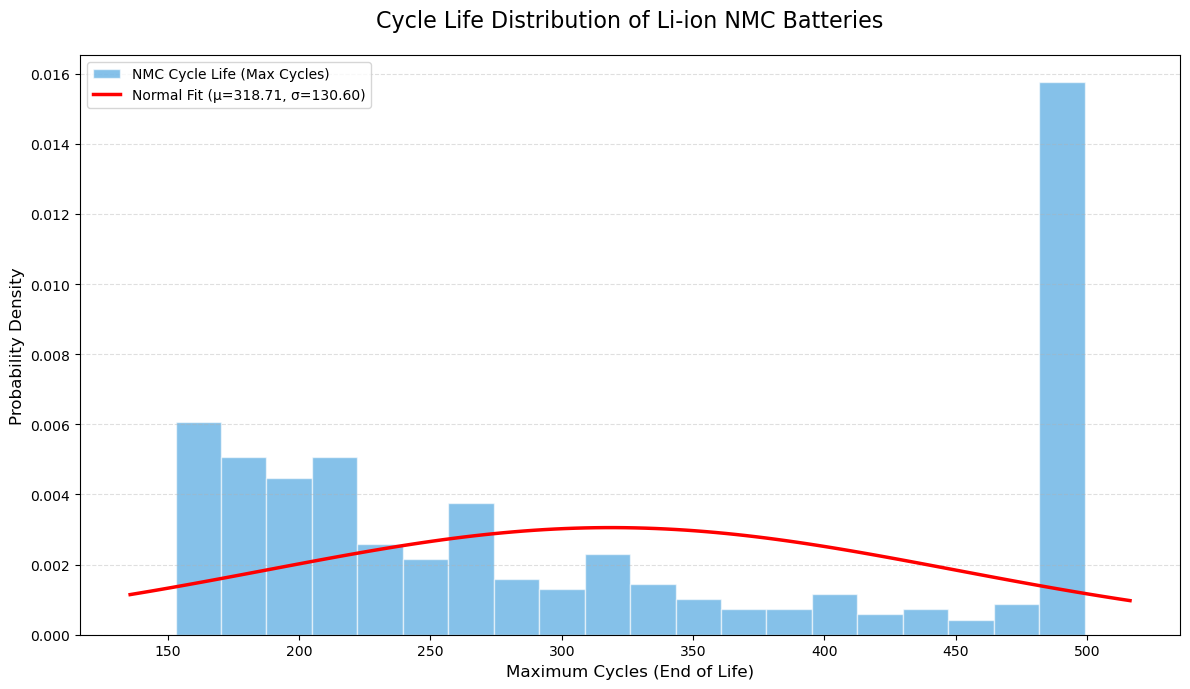

--------------------------------------------------
필터링 조건: cell_chemistry == 'Li-ion NMC'
추출된 배터리 개수 (샘플 수): 400 개
평균 수명 (μ): 318.71 cycles
수명 편차 (σ): 130.60 cycles
--------------------------------------------------


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. 파일 경로 설정
file_path = r'C:\Users\a6701\OneDrive - UOU\codingon\프로젝트1\battery_failure_surfaces.csv'

try:
    # 2. 데이터 불러오기
    df = pd.read_csv(file_path)
    
    # 3. Li-ion NMC 데이터만 필터링
    # cell_chemistry가 'Li-ion NMC'인 행만 선택합니다.
    nmc_df = df[df['cell_chemistry'] == 'Li-ion NMC'].copy()

    if nmc_df.empty:
        print("해당 조건(Li-ion NMC)에 맞는 데이터가 없습니다.")
    else:
        # 4. 각 배터리별 수명(최대 사이클) 추출
        # 사이클이 증가하다가 다음 행에서 0으로 작아지거나 리셋되는 지점이 '수명의 끝'입니다.
        # shift(-1)을 사용하여 현재 행과 다음 행을 비교해 마지막 사이클 지점을 찾습니다.
        # 마지막 행도 자동으로 포함되도록 설정합니다.
        is_end_of_life = (nmc_df['cycle'].shift(-1) <= nmc_df['cycle']) | (nmc_df['cycle'].shift(-1).isna())
        
        # 각 배터리의 최종 수명 데이터들만 모읍니다.
        cycle_lives = nmc_df.loc[is_end_of_life, 'cycle']

        # 5. 정규분포 통계량 계산
        # 결측치를 제거하지 말라고 하셨으므로, 계산 시에만 유효한 숫자들을 바탕으로 mu와 std를 구합니다.
        valid_cycles = cycle_lives.dropna()
        mu, std = norm.fit(valid_cycles)

        # 6. 시각화
        plt.figure(figsize=(12, 7))

        # 히스토그램 (실제 데이터 분포)
        plt.hist(valid_cycles, bins=20, density=True, alpha=0.6, color='#3498db', 
                 edgecolor='white', label='NMC Cycle Life (Max Cycles)')

        # 정규분포 곡선 그리기
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'r', linewidth=2.5, label=f'Normal Fit (μ={mu:.2f}, σ={std:.2f})')

        # 그래프 꾸미기
        plt.title('Cycle Life Distribution of Li-ion NMC Batteries', fontsize=16, pad=20)
        plt.xlabel('Maximum Cycles (End of Life)', fontsize=12)
        plt.ylabel('Probability Density', fontsize=12)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.4)

        plt.tight_layout()
        plt.show()

        # 결과 요약 출력
        print("-" * 50)
        print(f"필터링 조건: cell_chemistry == 'Li-ion NMC'")
        print(f"추출된 배터리 개수 (샘플 수): {len(valid_cycles)} 개")
        print(f"평균 수명 (μ): {mu:.2f} cycles")
        print(f"수명 편차 (σ): {std:.2f} cycles")
        print("-" * 50)

except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다. 경로를 확인해주세요: {file_path}")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")

## 사이클 횟수 기반 이상치 확인

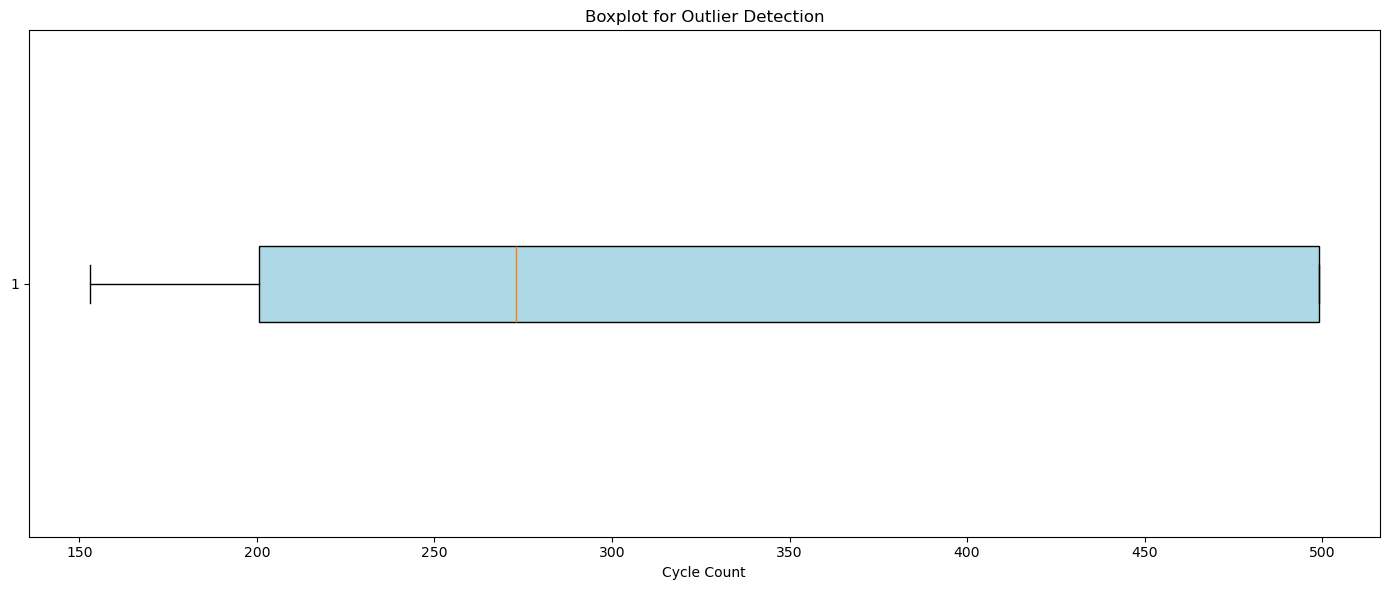


[IQR 기준 이상치] : 0개
기준 범위: -247.2 ~ 946.8
--------------------------------------------------


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. 데이터 불러오기 및 NMC 필터링
file_path = r'C:\Users\a6701\OneDrive - UOU\codingon\프로젝트1\battery_failure_surfaces.csv'
df = pd.read_csv(file_path)
nmc_df = df[df['cell_chemistry'] == 'Li-ion NMC'].copy()

# 배터리별 최종 수명 추출
is_end_of_life = (nmc_df['cycle'].shift(-1) < nmc_df['cycle']) | (nmc_df['cycle'].shift(-1).isna())
cycle_lives = nmc_df.loc[is_end_of_life, 'cycle'].dropna()

# 방법: IQR 기준
Q1 = cycle_lives.quantile(0.25)
Q3 = cycle_lives.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = cycle_lives[(cycle_lives < lower_bound) | (cycle_lives > upper_bound)]

# 3. 시각화 (Boxplot을 통해 이상치 확인)
plt.figure(figsize=(14, 6))


# 오른쪽: 박스플롯 (이상치가 점으로 표시됨)
plt.subplot(1, 1, 1)
plt.boxplot(cycle_lives, vert=False, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot for Outlier Detection')
plt.xlabel('Cycle Count')

plt.tight_layout()
plt.show()

# 결과 출력
print(f"\n[IQR 기준 이상치] : {len(outliers_iqr)}개")
print(f"기준 범위: {lower_bound:.1f} ~ {upper_bound:.1f}")
if not outliers_iqr.empty:
    print(outliers_iqr.values)
print("-" * 50)

## 결측치 확인

In [5]:
try:
    # 결측치 기본 정보 확인 (수치 데이터)
    null_counts = df.isnull().sum()  # 각 컬럼별 결측치 개수
    null_percentage = (null_counts / len(df)) * 100  # 각 컬럼별 결측치 비율

    # 결과 데이터프레임 생성
    null_summary = pd.DataFrame({
        'Missing Values': null_counts,
        'Percentage (%)': null_percentage
    }).sort_values(by='Missing Values', ascending=False)

    print("--- 컬럼별 결측치 요약 ---")
    print(null_summary)
    print("-" * 30)

except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
except Exception as e:
    print(f"오류 발생: {e}")

--- 컬럼별 결측치 요약 ---
                             Missing Values  Percentage (%)
cell_chemistry                            0             0.0
cycle                                     0             0.0
charge_rate_C                             0             0.0
discharge_rate_C                          0             0.0
cell_temperature_C                        0             0.0
internal_resistance_mOhm                  0             0.0
capacity_retention_%                      0             0.0
cumulative_high_temp_cycles               0             0.0
fast_charge_exposure_cycles               0             0.0
irreversible_damage_index                 0             0.0
thermal_runaway_risk_score                0             0.0
------------------------------


## 상관관계 분석 (선형)

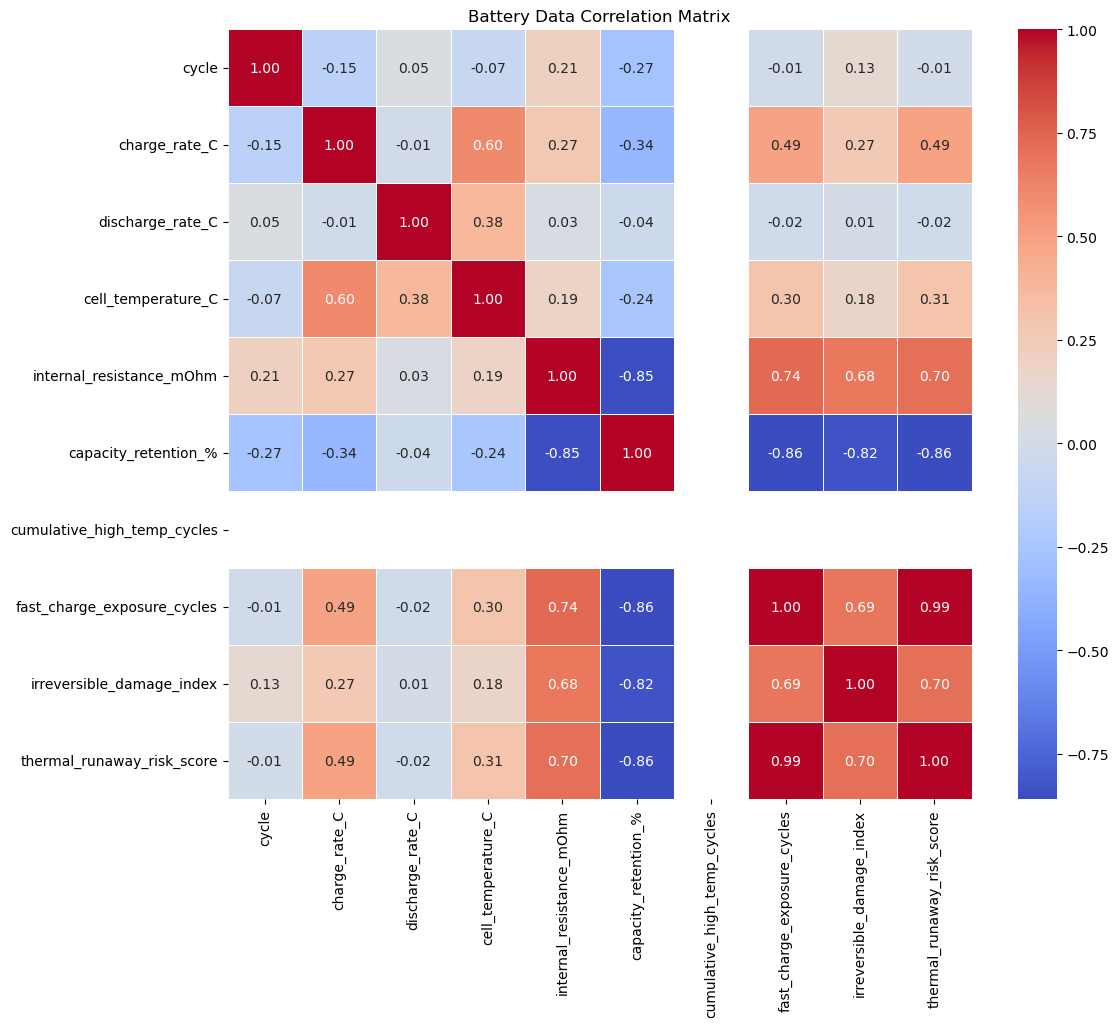

In [6]:
# 숫자 데이터만 필터링
numeric_df = df.select_dtypes(include=['number'])

# 상관계수 계산 (피어슨 상관계수)
corr = numeric_df.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Battery Data Correlation Matrix')
plt.show()

### 열폭주 위험도 
#### (1) cycle (상관계수 = -0.01): 연관성이 없다고 판단됨
#### (2) charge_rate_C (상관계수 = 0.49): 충전율이 높을수록 score가 오를확률이 크다고 판단됨, 하지만 해당 상관계수로써는 정확한 파악은 불가
#### (3) discharge_rate_C (상관계수 = -0.02): 연관성이 없다고 판단됨
#### (4) cell_temperature_C (상관계수 = 0.31): 연관성이 높지는 않다고 판단됨
#### (5) thermal_resistance_mOhm (상관계수 = 0.7): 내부저항과 score 연관 있다고 판단됨
#### (6) capacity_retention_%(상관계수 = -0.86): 배터리 수명과 score에는 깊은 연관이 있다 판단됨
#### (7) cumulative_high_cycles(x): 모든 값이 0이며 제거
#### (8) fast_charge_exposure_cycles(상관계수 = 0.99): 매우 큰 연관 급속충전 노출횟수는 score에 확정적으로 영향을 끼침
#### (9) irreversible_damage_index(상관계수 = 0.7): 내부저항과 마찬가지고 score와 연관 있다고 판단됨 

## cumulative_high_temp_cycles 값이 전부 0인지 확인

In [7]:
# 방법 1: 최댓값 확인 (0이라면 전부 0)
print(f"최댓값: {df['cumulative_high_temp_cycles'].max()}")

# 방법 2: 0이 아닌 값의 개수 세기
non_zero_count = (df['cumulative_high_temp_cycles'] != 0).sum()
print(f"0이 아닌 데이터 개수: {non_zero_count}개")


최댓값: 0
0이 아닌 데이터 개수: 0개


## 상관관계 분석(비선형)

c:\Users\a6701\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


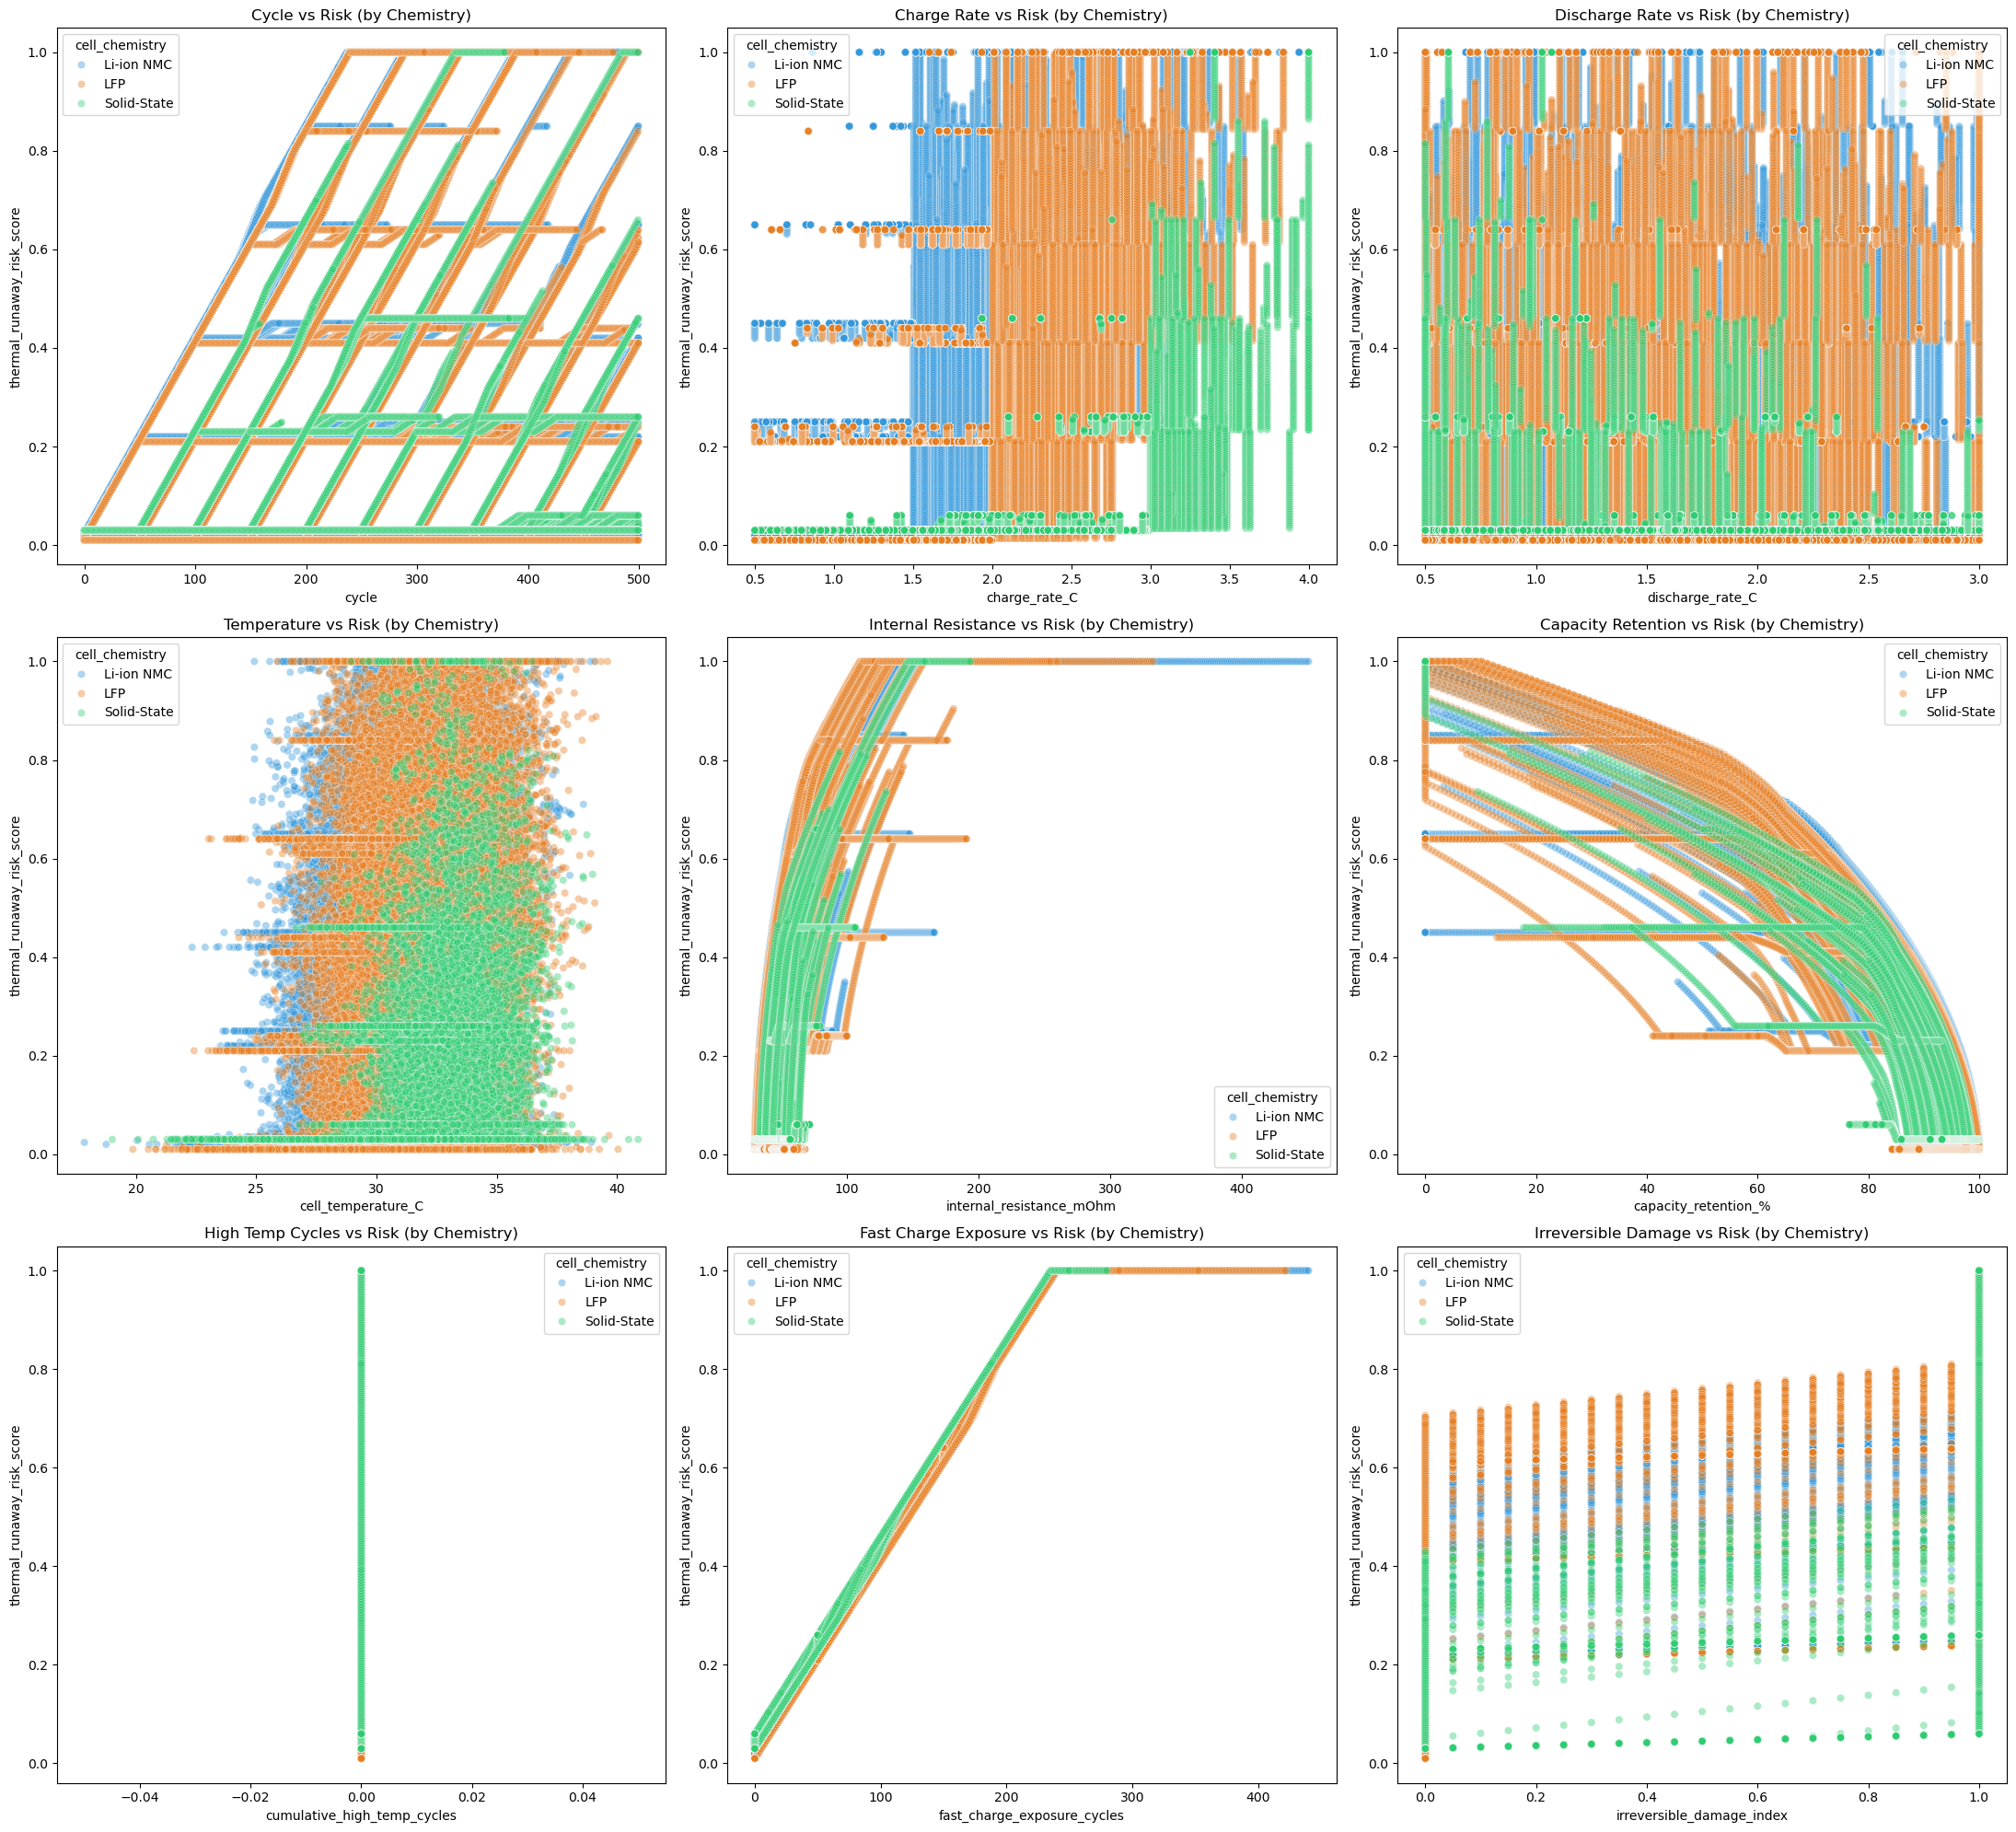

In [10]:
# 2. 시각화 설정 (3행 3열)
# 배터리 종류별로 색상을 구분(hue)하여 경계의 차이를 명확히 합니다.
plt.figure(figsize=(22, 20))
custom_palette = {'Li-ion NMC': '#3498db', 'LFP': '#e67e22', 'Solid-State': '#2ecc71'}

# --- [1] Cycle vs Risk ---
plt.subplot(3, 3, 1)
sns.scatterplot(data=df, x='cycle', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Cycle vs Risk (by Chemistry)')

# --- [2] Charge Rate vs Risk ---
plt.subplot(3, 3, 2)
sns.scatterplot(data=df, x='charge_rate_C', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Charge Rate vs Risk (by Chemistry)')

# --- [3] Discharge Rate vs Risk ---
plt.subplot(3, 3, 3)
sns.scatterplot(data=df, x='discharge_rate_C', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Discharge Rate vs Risk (by Chemistry)')

# --- [4] Temperature vs Risk ---
plt.subplot(3, 3, 4)
sns.scatterplot(data=df, x='cell_temperature_C', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Temperature vs Risk (by Chemistry)')

# --- [5] Internal Resistance vs Risk ---
plt.subplot(3, 3, 5)
sns.scatterplot(data=df, x='internal_resistance_mOhm', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Internal Resistance vs Risk (by Chemistry)')

# --- [6] Capacity Retention vs Risk ---
plt.subplot(3, 3, 6)
sns.scatterplot(data=df, x='capacity_retention_%', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Capacity Retention vs Risk (by Chemistry)')

# --- [7] High Temp Cycles vs Risk ---
plt.subplot(3, 3, 7)
sns.scatterplot(data=df, x='cumulative_high_temp_cycles', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('High Temp Cycles vs Risk (by Chemistry)')

# --- [8] Fast Charge Exposure vs Risk ---
plt.subplot(3, 3, 8)
sns.scatterplot(data=df, x='fast_charge_exposure_cycles', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Fast Charge Exposure vs Risk (by Chemistry)')

# --- [9] Irreversible Damage vs Risk ---
plt.subplot(3, 3, 9)
sns.scatterplot(data=df, x='irreversible_damage_index', y='thermal_runaway_risk_score', hue='cell_chemistry', palette=custom_palette, alpha=0.4)
plt.title('Irreversible Damage vs Risk (by Chemistry)')

plt.tight_layout()
plt.show()    

### (1) 사이클과 score 비교 결과: 유사한 패턴을 보이는 특성을 보아 일정한 규칙을 적용시켜 시뮬레이션을 실행했다고 판단됨.
### (2) 충전율과 score 비교 결과: 배터리 종류별 상이한 충전율 시뮬레이션 적용
### (3) 방전율과 score 비교 결과: 뚜렷하게 구분되는 특징을 찾는것은 불가
### (4) 온도와 score 비교 결과: 배터리 셀의 온도 단일변수와 score의 연관성을 판단하는 것은 불가능하다고 판단되지만, 전고체의 배터리는 다른 배터리에 비해 셀온도 영향이 상당히 작다는 것을 알 수 있음
### (5) 내부저항과 score 비교 결과: 3종류 배터리 모두 내부저항에 의한 score 영향이 매우 유사하다
### (6) 배터리 수명과 score 비교 결과: 배터리 수명이 작을수록 score가 비례적으로 증가하며 이는 모든 배터리가 유사함
### (7) 생략
### (8) 급속충전노출횟수와 scroe 비교 결과: 3종류 전부 동일한 경향
### (9) 비가역적 손상 정도와 score 비교 결과: 상대적으로 전고체 배터리는 다른 2종류에 비해 영향이 적음

### => 상대적으로 성능이 좋은 전고체 배터리와 LFP 배터리보단, Li-ion 배터리에 대한 임계치를 파악하는 것이 더 좋다고 판단됨 

## 상관관계 분석(Li-ion배터리만)

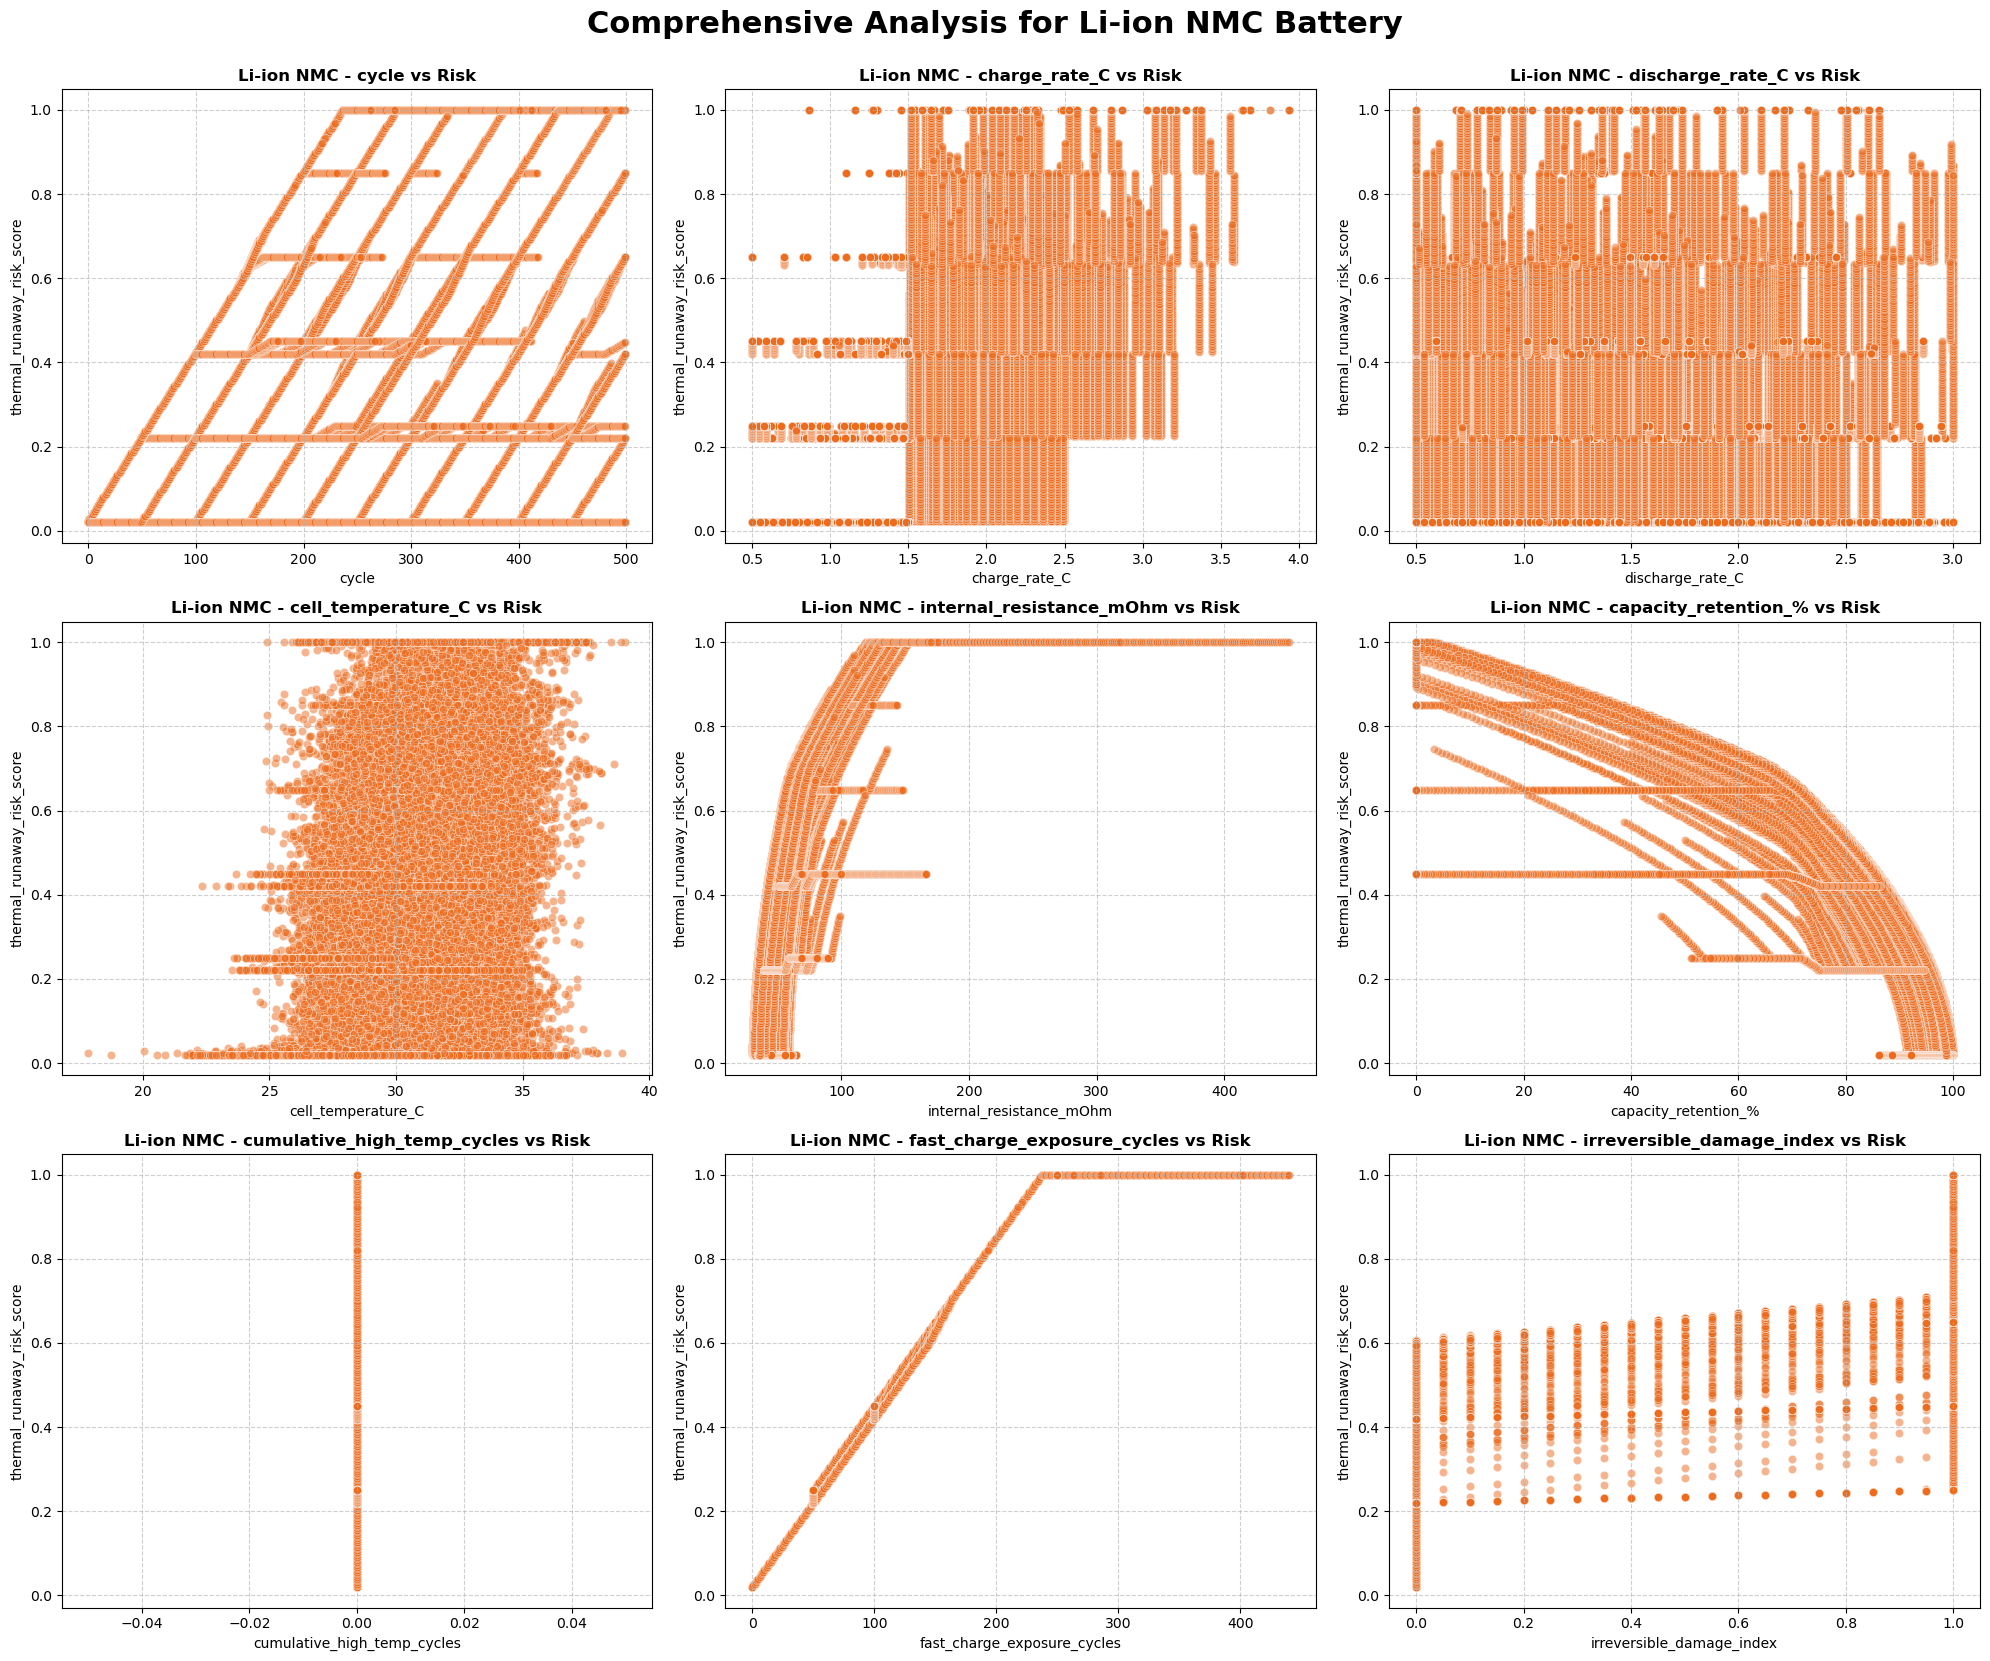

In [ ]:
# 분석할 독립변수 9개 리스트
independent_vars = [
    'cycle', 'charge_rate_C', 'discharge_rate_C', 
    'cell_temperature_C', 'internal_resistance_mOhm', 'capacity_retention_%',
    'cumulative_high_temp_cycles', 'fast_charge_exposure_cycles', 'irreversible_damage_index'
]

# 배터리 종류 및 테마 색상 설정
chemistries = ['Li-ion NMC']
colors = ['Oranges_d']

# 2. 종류별로 루프를 돌며 9개 그래프씩 3번 출력
for chem, color_theme in zip(chemistries, colors):
    # 해당 종류의 데이터만 추출
    subset = df[df['cell_chemistry'] == chem]
    
    # 새로운 그림(Figure) 생성
    plt.figure(figsize=(20, 18))
    
    for i, var in enumerate(independent_vars):
        plt.subplot(3, 3, i + 1)
        
        # 산점도 그리기
        sns.scatterplot(
            data=subset, 
            x=var, 
            y='thermal_runaway_risk_score', 
            color=sns.color_palette(color_theme)[2], # 테마색 적용
            alpha=0.5
        )
        
        plt.title(f'{chem} - {var} vs Risk', fontsize=12, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.6)

    plt.suptitle(f'Comprehensive Analysis for {chem} Battery', fontsize=22, y=0.95, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # 각 종류별로 창을 띄움

### 해당 데이터만으로는 정확한 분석이 불가능하다고 판단되어 배터리 1개의 생애주기를 파악하고자 함

## 배터리 샘플 1개 분석

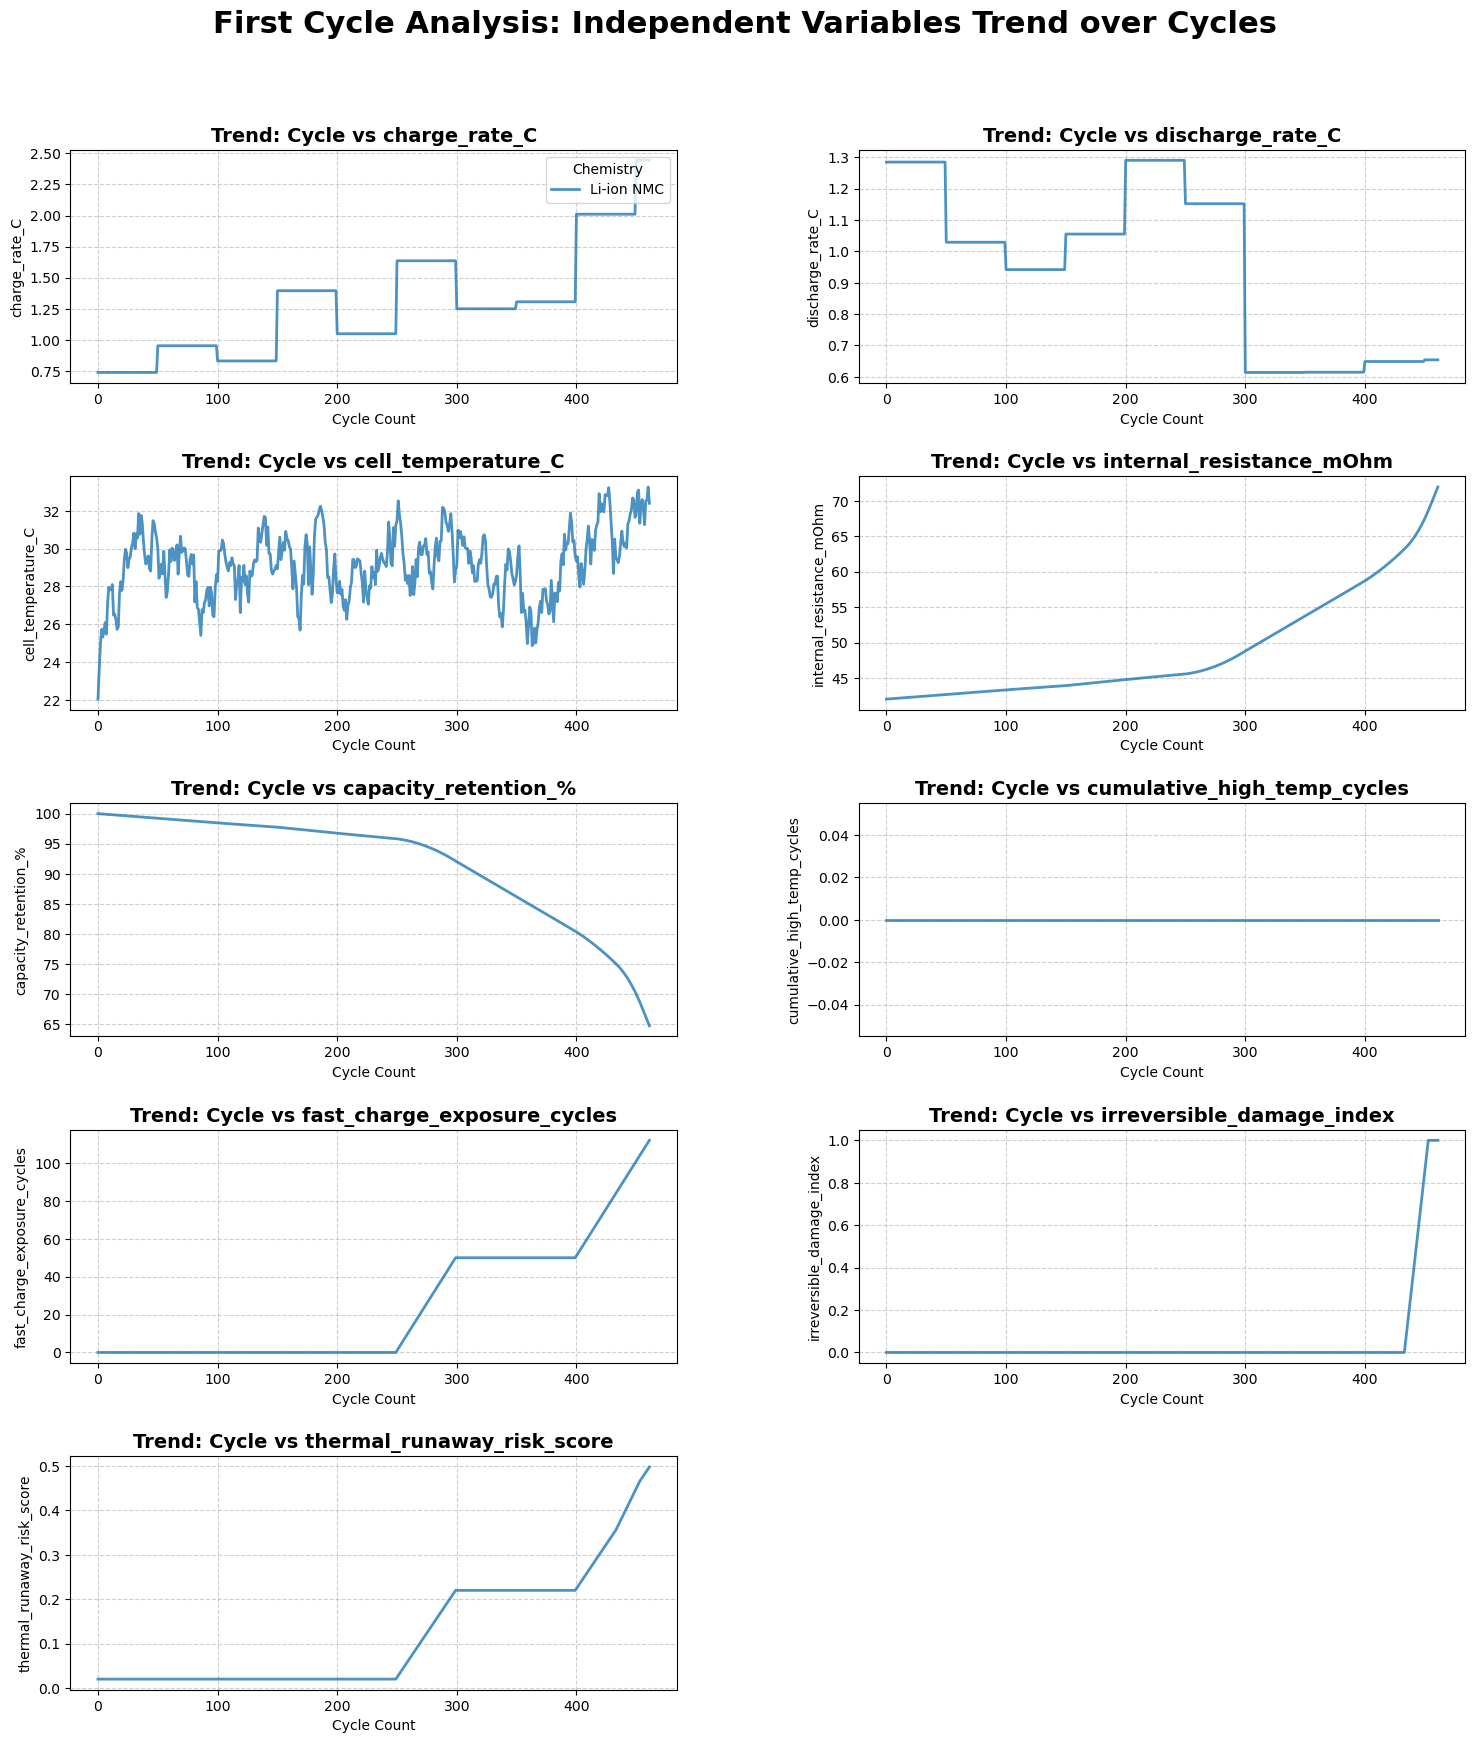

--- [첫 번째 사이클 구간 요약 통계 (462개 샘플)] ---


charge_rate_C  discharge_rate_C  cell_temperature_C  \
count     462.000000        462.000000          462.000000   
mean        1.272008          0.951164           29.171501   
std         0.423960          0.260065            1.763956   
min         0.737649          0.613931           22.036731   
25%         0.952380          0.648827           28.091195   
50%         1.249798          1.029289           29.223002   
75%         1.395151          1.152154           30.314954   
max         2.444084          1.290551           33.259746   

       internal_resistance_mOhm  capacity_retention_%  \
count                462.000000            462.000000   
mean                  48.858201             91.929729   
std                    7.318968              8.610550   
min                   42.011294             64.762492   
25%                   43.499632             86.692072   
50%                   45.250171             96.174471   
75%                   53.310209             98.233928   
max                   71.950353             99.984914   

       cumulative_high_temp_cycles  fast_charge_exposure_cycles  \
count                        462.0                   462.000000   
mean                           0.0                    24.519481   
std                            0.0                    31.133445   
min                            0.0                     0.000000   
25%                            0.0                     0.000000   
50%                            0.0                     0.000000   
75%                            0.0                    50.000000   
max                            0.0                   112.000000   

       irreversible_damage_index  thermal_runaway_risk_score  
count                 462.000000                  462.000000  
mean                    0.040043                    0.119279  
std                     0.176948                    0.127618  
min                     0.000000                    0.020000  
25%                     0.000000                    0.020000  
50%                     0.000000                    0.020000  
75%                     0.000000                    0.220000  
max                     1.000000                    0.498000

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 파일 경로 설정
file_path = r'C:\Users\a6701\OneDrive - UOU\codingon\프로젝트1\battery_failure_surfaces.csv'

# 2. 데이터 불러오기
df = pd.read_csv(file_path, encoding='UTF-8')

try:
    df = pd.read_csv(file_path, encoding='UTF-8')
 
    
    # 2. 첫 번째 사이클 구간 추출 (0부터 다음 0이 오기 전까지)
    zero_indices = df.index[df['cycle'] == 0].tolist()
    if len(zero_indices) > 1:
        first_cycle_df = df.iloc[zero_indices[2] : zero_indices[3]]
    else:
        first_cycle_df = df.copy() # 0이 하나뿐이면 전체 데이터 사용

    # 3. 시각화할 독립변수 리스트 (위험 점수 제외)
    target_vars = [
        'charge_rate_C', 'discharge_rate_C', 'cell_temperature_C', 
        'internal_resistance_mOhm', 'capacity_retention_%', 
        'cumulative_high_temp_cycles', 'fast_charge_exposure_cycles', 
        'irreversible_damage_index', 'thermal_runaway_risk_score'
    ]

    # 4. 2차원 그래프 시각화 (5행 2열 구조)
    plt.figure(figsize=(18, 20))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, var in enumerate(target_vars):
        plt.subplot(5, 2, i + 1)
        
        # 선 그래프로 추이 파악 (배터리 종류별로 구분)
        sns.lineplot(
            data=first_cycle_df, 
            x='cycle', 
            y=var, 
            hue='cell_chemistry',
            linewidth=2,
            alpha=0.8
        )
        
        plt.title(f'Trend: Cycle vs {var}', fontsize=14, fontweight='bold')
        plt.xlabel('Cycle Count', fontsize=10)
        plt.ylabel(var, fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # 범례는 첫 번째 그래프에만 표시하거나 위치 조정
        if i != 0:
            plt.legend().remove()
        else:
            plt.legend(title='Chemistry', loc='upper right')

    plt.suptitle('First Cycle Analysis: Independent Variables Trend over Cycles', fontsize=22, y=0.95, fontweight='bold')
    plt.show()

    # 5. 데이터 요약 통계 출력 (가독성 좋은 표 형식)
    print(f"--- [첫 번째 사이클 구간 요약 통계 ({len(first_cycle_df)}개 샘플)] ---")
    display(first_cycle_df[target_vars].describe())

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인해 주세요.\n경로: {file_path}")
except Exception as e:
    print(f"분석 중 오류가 발생했습니다: {e}")